# **Test integration of DP Langevin**

Simple Jupyter notebook testing an adaptation of the Villa Martín/Buendía (VMB)
implementation of the Dornic et al (2005) method of integrating DP/APT-type
Langevin equations using an operator-splitting method. Access to the heavily 
refactored VMB C++ code is provided via a pybind11 wrapper.

See the main README for references.

<hr>

## Preliminaries

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numpy.typing import NDArray
import dplvn
import initialize

<hr>

## Package `dplvn` info

In [2]:
print(f"dplvn version:  {dplvn.__version__}")

dplvn version:  2025.09.15a1


In [3]:
help(dplvn)

Help on module dplvn:

NAME
    dplvn - Operator-splitting method of integrating DP-type Langevin equations

CLASSES
    pybind11_builtins.pybind11_object(builtins.object)
        BoundaryCondition
        GridDimension
        GridTopology
        InitialCondition
        IntegrationMethod
        SimDP

    class BoundaryCondition(pybind11_builtins.pybind11_object)
     |  Method resolution order:
     |      BoundaryCondition
     |      pybind11_builtins.pybind11_object
     |      builtins.object
     |
     |  Methods defined here:
     |
     |  __eq__(...)
     |      __eq__(self: object, other: object, /) -> bool
     |
     |  __getstate__(...)
     |      __getstate__(self: object, /) -> int
     |
     |  __hash__(...)
     |      __hash__(self: object, /) -> int
     |
     |  __index__(...)
     |      __index__(self: dplvn.BoundaryCondition, /) -> int
     |
     |  __init__(...)
     |      __init__(self: dplvn.BoundaryCondition, value: typing.SupportsInt) -> None
     

In [4]:
help(dplvn.SimDP)

Help on class SimDP in module dplvn:

class SimDP(pybind11_builtins.pybind11_object)
 |  Method resolution order:
 |      SimDP
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  __init__(...)
 |      __init__(self: dplvn.SimDP, linear: typing.SupportsFloat = 1.0, quadratic: typing.SupportsFloat = 2.0, diffusion: typing.SupportsFloat = 0.1, noise: typing.SupportsFloat = 1.0, t_max: typing.SupportsFloat = 100.0, dx: typing.SupportsFloat = 0.5, dt: typing.SupportsFloat = 0.01, random_seed: typing.SupportsInt = 1, grid_dimension: dplvn.GridDimension = <GridDimension.D2: 2>, grid_size: collections.abc.Sequence[typing.SupportsInt] = [0, 0, 0, 0], grid_topology: dplvn.GridTopology = <GridTopology.BOUNDED: 1>, boundary_condition: dplvn.BoundaryCondition = <BoundaryCondition.FLOATING: 1>, initial_condition: dplvn.InitialCondition = <InitialCondition.RANDOM_UNIFORM: 1>, integration_method: dplvn.IntegrationMethod = <IntegrationMethod.RUNGE_KUTT

<hr>

## Demo

Perform demo integration of a DP Langevin on a 64 $\times$ 64 grid 
(4096 cells) with simple choices of parameters.

In [5]:
sim_dp = dplvn.SimDP(
    linear=1.0, quadratic=2.0, diffusion=0.1, noise=1.0, 
    t_max=50.0-1e-10, 
    dx=0.5, dt=0.01,
    random_seed=1,
    # grid_dimension=dplvn.D1,
    # grid_size=(4096,),
    grid_dimension=dplvn.D2,
    grid_size=(8,8,),
    # grid_size=(64,64,),
    grid_topology=dplvn.BOUNDED,
    boundary_condition=dplvn.FLOATING,
    initial_condition=dplvn.RANDOM_UNIFORM,
    integration_method=dplvn.RUNGE_KUTTA
)

linear: 1
quadratic: 2
diffusion: 0.1
noise: 1
t_max: 50
dx: 0.5
dt: 0.01
random_seed: 1
grid_dimension: 2d
grid_size: 8 8 
n_cells: 64
grid_topology: bounded
boundary_condition: floating
initial_condition: random uniform values
integration_method: Runge-Kutta


In [6]:
if not sim_dp.initialize():
    raise Exception("Failed to initialize sim")
if not sim_dp.run():
    raise Exception("Failed to run sim")

Simulation results are returned as a `numpy` array with integration time steps
("epochs") in the first column and grid-mean density ("mean_densities") in the
second column. 

In [7]:
epochs: NDArray = sim_dp.get_epochs()
mean_densities: NDArray = sim_dp.get_mean_densities()
epochs[-10:], mean_densities[-10:]

(array([49.91, 49.92, 49.93, 49.94, 49.95, 49.96, 49.97, 49.98, 49.99,
        50.  ]),
 array([0.09789199, 0.10045128, 0.09356447, 0.09125034, 0.09343846,
        0.08927427, 0.08251734, 0.08935198, 0.090392  , 0.09421479]))

In [8]:
density: NDArray = sim_dp.get_density()
np.round(density, 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.37, 0.  , 0.  , 0.  ],
       [0.16, 0.  , 0.  , 0.01, 0.05, 0.02, 0.22, 0.02],
       [0.24, 0.53, 0.13, 1.05, 0.85, 0.07, 0.02, 0.34],
       [0.09, 0.11, 0.1 , 0.41, 0.54, 0.01, 0.  , 0.14],
       [0.  , 0.02, 0.06, 0.01, 0.01, 0.01, 0.  , 0.25],
       [0.01, 0.18, 0.  , 0.  , 0.  , 0.  , 0.02, 0.  ]])

<hr>

## Plot results

Plot the time-series of grid-averaged density field.

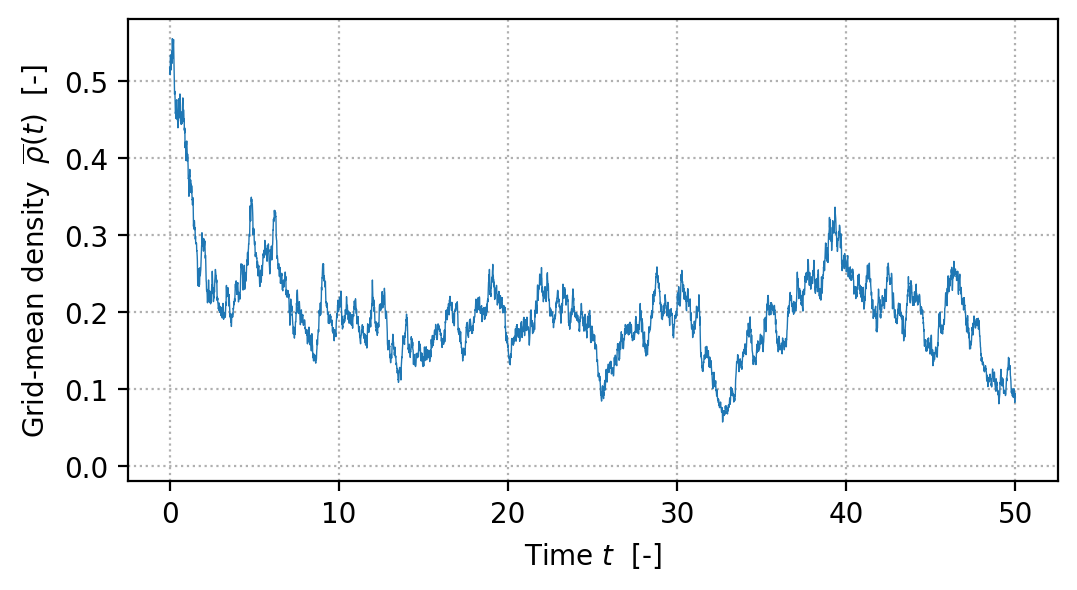

In [9]:
fig = plt.figure(figsize=(6,3))
plt.plot(epochs, mean_densities, "-", lw=0.5,)
plt.xlabel(r"Time $t$  [-]")
plt.ylabel(r"Grid-mean density  $\overline{\rho}(t)$  [-]")
plt.ylim(-0.02, None)
plt.grid(ls=":")

In [10]:
fig.savefig(
    "meandensity_time.png",
    bbox_inches="tight",
    pad_inches=0.05,
    dpi=150,
    format="PNG",
)